In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

pd.set_option('max_columns', 100)

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import time


# torch things
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


# Extras
import math, string, os
from string import punctuation
import re
import math
from scipy.spatial import Voronoi, voronoi_plot_2d
import copy

# xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

# new 
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# parameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 10*BATCH_SIZE
EPOCHS = 150
DROPOUT_RATE = 0.25
DEPTH = 5
WIDTH = 128
LEARNING_RATE = 1e-4
NOISY=0.00005
# NOISY=1.5
BIG_YARDCUTOFF = 30
SMALL_YARDCUTOFF = -100

# cuda stuff
USE_CUDA = False
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## NN only

In [ ]:
eps = 1e-10

class FullyConnected(nn.Module):
    def __init__(self, in_dim, out_dim, depth=1, width=500, dropout_rate=0.1):
        """
        Mama mia
        """
        super(FullyConnected, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.depth = depth
        self.width = width
        self.dropout_rate = dropout_rate

        # build model layers
        mid_layer = [nn.Linear(width, width), nn.ReLU(), nn.Dropout(dropout_rate)]

        all_layers = [nn.Linear(in_dim, width), nn.ReLU()]
        for d in range(depth):
            all_layers.extend(mid_layer)
        all_layers.append(nn.Linear(width, out_dim))
        all_layers.append(nn.Softmax(dim=1))


        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        out = self.model(x)
        out = torch.clamp(out.cumsum(1), min=eps, max=1 - eps)
        return out

    def loss(self, guess, label, device):
        # L = F.binary_cross_entropy(guess, label.to(device))
        # L = torch.mean(torch.sum(torch.pow(guess-label,2))/(199))
        L = F.mse_loss(guess, label) + F.mse_loss(guess.sum(), label.sum())*1/(100000000)
        # L = F.mse_loss(guess.sum(), label.sum())/F.mse_loss(guess, label)

        return L

class ResFullyConnected(nn.Module):
    def __init__(self, in_dim, out_dim, depth=1, width=500, dropout_rate=0.1):
        """
        Mama mia
        """
        super(ResFullyConnected, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.depth = depth
        self.width = width
        self.dropout_rate = dropout_rate

        # build model layers
        mid_layer = [nn.Linear(width, width), nn.ReLU(), nn.Dropout(dropout_rate)]

        all_layers = [nn.Linear(in_dim, width), nn.ReLU()]
        for d in range(depth):
            all_layers.extend(mid_layer)
        all_layers.append(nn.Linear(width, out_dim))
        all_layers.append(nn.Softmax(dim=1))
        # self.model = nn.Sequential(*all_layers)
        # self.model = all_layers
        self.layers = all_layers

    def forward(self, x):
        out = self.layers[0](x)
        out = self.layers[1](x)
        for i, layer in enumerate(self.layers[2:-2]):
            # skip connections inside
            if i % 3 == 2:
                # because each mid layer has 3 sublayers
                out = layer(out)
                out = self.layers[i+1](out)
                out = self.layers[i+2](out) + out
        out = self.layers[-2](out)
        out = self.layers[-1](out)
        
        out = torch.clamp(out.cumsum(1), min=eps, max=1 - eps)
        return out

    def loss(self, guess, label, device):
        L = F.binary_cross_entropy(guess, label.to(device))
        return L

def train(model, device, train_loader, optimizer, epoch, log_interval=1e5, verbose=True):
    model.train()
    train_loss = 0

    for batch_idx, (data, yardage) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = model.loss(output, yardage, device)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if batch_idx % log_interval == 0:
            if verbose:
                print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()), epoch, batch_idx * len(data),
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)
    if verbose:
        print('Train set Average loss:', train_loss)
    return train_loss

def label_to_cdf(label, noisy=None):
    """
    labels are the yards gained. thus the cdf is a step function at yards gained

    noisy: treat yards as a gaussian centered on label with sigma = noisy
    """
    label = label + 99 # to adjust for negative yards
    if noisy:
        # noisy = number of bins to noise over
        bins = [199 - i for i in range(199)]
        cdf = norm.cdf(bins, 199 - label, noisy)
    else:
        cdf = np.sum(np.eye(199)[:label], axis=0) 
    return 1 - cdf

def test(model, device, test_loader, log_interval=1e5, verbose=True, return_predictions=False):
    model.eval()
    test_loss = 0

    all_predictions = []

    with torch.no_grad():
        for batch_idx, (data, yardage) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            all_predictions.append(output)
            loss = model.loss(output, yardage, device)
            test_loss += loss.item()

            if log_interval is not None and batch_idx % log_interval == 0:
                if verbose:
                    print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        time.ctime(time.time()),
                        batch_idx * len(data), len(test_loader.dataset),
                        100. * batch_idx / len(test_loader), loss.item()))

    test_loss /= len(test_loader)
    if verbose:
        print('Test set Average loss:', test_loss)

    if return_predictions:
        return all_predictions, test_loss
    return test_loss


class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        'Initialization'
        self.data = data
        self.labels = labels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]
        return X, y

## Training stuff

In [ ]:
def make_model(IN_DIM, OUT_DIM, width=100, dropout_rate=0.35):
    # model = FullyConnected(IN_DIM, OUT_DIM, dropout_rate=dropout_rate, width=width)
    model = ResFullyConnected(IN_DIM, OUT_DIM, dropout_rate=dropout_rate, width=width)
    return model

xTrainMin = -7777777
def train_model(df, scaler=None, pca=None, width=128): 
    # data already processed
    # xTrain = process(df, test_or_train='train')
    # playId = df['PlayId']
    df = df[df.Yards < BIG_YARDCUTOFF].reset_index(drop=True)
    df = df[df.Yards > SMALL_YARDCUTOFF].reset_index(drop=True)
    yTrain = df['Yards']
    xTrain = df.drop(['Season', 'Quarter', 'WindSpeed'], axis=1)
    # drop all PlayIDs
    xTrain = xTrain.infer_objects()
    xTrain = xTrain.drop([col for col in xTrain.columns if 'PlayId' in col], axis=1)
    xTrain = xTrain.drop([col for col in xTrain.columns if 'NflId' in col], axis=1)
    xTrain = xTrain.select_dtypes(exclude=['object'])

    xTrain = xTrain.drop(['GameId', 'Yards'], axis=1)
    
    # xTrain = xTrain[[col for col in xTrain.columns if ('Voronoi' in col or 'DistanceToRB' in col or 'X_' in col or 'Y' in col or 'S_' in col or 'A_' in col)]]

    # print(xTrain.min()/xTrainMin)
    xTrain = np.log(xTrain - xTrainMin + eps) # to bring things much closer

    x = xTrain

    # clip large outlier values
    clip_min = x.quantile(0.0005, axis=0)
    clip_max = x.quantile(0.9995, axis=0)
    # x = x.clip(clip_min, clip_max, axis=1)

    # std mask
    stdMask = None
    # stdMask = stdMask & (x[x <= x.quantile(0.999)].dropna().std() <= 1000)
    # stdMask = 0 < x[x <= x.quantile(0.999)].dropna().std() 
    # x = x[stdMask]

    # standard scaler
    if scaler == None:
        scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.transform(x)


    # PCA preprocessing
    if pca == None:
        pca = PCA(n_components=max(20, x.shape[-1]//2))
        # pca = FunctionTransformer()
    pca.fit(x)
    x = pca.transform(x)
    print(x.shape)
    x = x.astype('float32')

    # set up labels
    y = np.array([label_to_cdf(l, noisy=NOISY) for l in yTrain])
    y = y.astype('float32')

    # make validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    train_loader = DataLoader(Dataset(x_train, y_train), 
                              batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(Dataset(x_val, y_val), 
                              batch_size=BATCH_SIZE, shuffle=True)
    # make model
    IN_DIM = x.shape[-1]
    OUT_DIM = 199
    model = FullyConnected(IN_DIM, OUT_DIM, dropout_rate=DROPOUT_RATE, 
                           depth=DEPTH, width=WIDTH)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # model = ResFullyConnected(IN_DIM, OUT_DIM, dropout_rate=DROPOUT_RATE, width=WIDTH)
    # optimizer = torch.optim.Adam([params for layer in model.layers for params in layer.parameters()], lr=LEARNING_RATE)
    
    
    # train nn
    best_loss = 1e10
    best_epoch = 0
    early_stopping = 30
    for epoch in range(0, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, 
                                      epoch, verbose=True)
        valid_loss = test(model, device, valid_loader, verbose=True)

        if valid_loss < best_loss:
            print("victory")
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)
        
        if epoch - best_epoch > early_stopping:
            break

    return best_model, stdMask, pca, scaler, clip_min, clip_max
    

def test(model, device, test_loader, log_interval=1e5, verbose=True, return_predictions=False):
    model.eval()
    test_loss = 0

    all_predictions = []

    with torch.no_grad():
        for batch_idx, (data, yardage) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            all_predictions.append(output)
            loss = model.loss(output, yardage, device)
            test_loss += loss.item()

            if log_interval is not None and batch_idx % log_interval == 0:
                if verbose:
                    print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        time.ctime(time.time()),
                        batch_idx * len(data), len(test_loader.dataset),
                        100. * batch_idx / len(test_loader), loss.item()))

    test_loss /= len(test_loader)
    if verbose:
        print('Test set Average loss:', test_loss)

    if return_predictions:
        return all_predictions, test_loss
    return test_loss


def predict(model, test_df, stdMask=None, clip_min=-1e10, clip_max=1e10,
            pca=FunctionTransformer, scaler=FunctionTransformer):
    model.eval()
    playId = test_df['PlayId']
    # xTest = process(test_df, test_or_train='test')
    xTest = test_df.drop(['Season', 'Quarter', 'WindSpeed'], axis=1)
    # drop all PlayIDs
    xTest = xTest.infer_objects()
    xTest = xTest.drop([col for col in xTest.columns if 'PlayId' in col], axis=1)
    xTest = xTest.drop([col for col in xTest.columns if 'NflId' in col], axis=1)
    xTest = xTest.select_dtypes(exclude=['object'])
    xTest = xTest.drop(['GameId'], axis=1)

    # xTest = xTest[[col for col in xTest.columns if ('Voronoi' in col or 'DistanceToRB' in col or 'X_' in col or 'Y' in col or 'S_' in col or 'A_' in col)]]
    
    xTest = np.log(xTest - xTrainMin + eps) # to bring things much closer
    x = xTest 

    # clip large outlier values
    # x = x.clip(clip_min, clip_max, axis=1)

    # std scaling
    x = scaler.transform(x)

    # std Mask
    if type(stdMask) != type(None):
        x = x[:, stdMask]

    # PCA preprocessing
    print(x.shape)
    x = pca.transform(x)
    x = x.astype('float32')
    
    data = torch.tensor(x)
#     print(data)
    cdfVals = model(data).detach()
    
    return cdfVals



## Run Training

In [ ]:
# View Available Files
from google.colab import drive

drive.mount('/content/gdrive')

# Training data is in the competition dataset as usual
df = pd.read_csv('/content/gdrive/My Drive/nfl/JT/NN Models/processed_data.csv')\


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk].reset_index(drop=True)
test_df = df[~msk].reset_index(drop=True)

begin_time = time.time()
ensemble = []
n_models = 1
scaler = None
pca = None
for i in range(n_models):
    rand_width = np.random.randint(25, 1000)
    model, stdMask, pca, scaler, clip_min, clip_max = train_model(train_df, scaler=scaler, pca=pca, width=rand_width)
    ensemble.append(model)

print(time.time() - begin_time)

print("Training done. Start predicting.")

(18325, 226)
Wed Nov 27 16:58:19 2019 Train Epoch: 0 [0/14660 (0%)]	Loss: 0.281748
Train set Average loss: 0.2524704466263453
Wed Nov 27 16:58:20 2019 Test: [0/3665 (0%)]	Loss: 0.251662
Test set Average loss: 0.2195948213338852
victory
Wed Nov 27 16:58:20 2019 Train Epoch: 1 [0/14660 (0%)]	Loss: 0.227618
Train set Average loss: 0.20944537470738092
Wed Nov 27 16:58:20 2019 Test: [0/3665 (0%)]	Loss: 0.197053
Test set Average loss: 0.1787843331694603
victory
Wed Nov 27 16:58:20 2019 Train Epoch: 2 [0/14660 (0%)]	Loss: 0.180370
Train set Average loss: 0.15228268603483835
Wed Nov 27 16:58:21 2019 Test: [0/3665 (0%)]	Loss: 0.125865
Test set Average loss: 0.1168457418680191
victory
Wed Nov 27 16:58:21 2019 Train Epoch: 3 [0/14660 (0%)]	Loss: 0.116283
Train set Average loss: 0.08967012812693914
Wed Nov 27 16:58:21 2019 Test: [0/3665 (0%)]	Loss: 0.083052
Test set Average loss: 0.08217332325875759
victory
Wed Nov 27 16:58:21 2019 Train Epoch: 4 [0/14660 (0%)]	Loss: 0.088243
Train set Average los

In [ ]:
columns = list(df.columns)
columns.remove("Yards")
columns.remove("GameId")
columns.remove("PlayId")

X_train = train_df[columns]
y_train = train_df["Yards"]

y = y_train.values
target = y[np.arange(0, len(X_train), 22)]
standard_deviation = np.std(target)

str_cols = ["Team", "GameClock", "FieldPosition", "PlayDirection", "TimeHandoff", 
            "TimeSnap", "DisplayName_O_0", "PlayerBirthDate_O_0", "DisplayName_O_1", 
            "PlayerBirthDate_O_1", "DisplayName_O_2", "PlayerBirthDate_O_2", 
            "DisplayName_O_3", "PlayerBirthDate_O_3", "DisplayName_O_4", 
            "PlayerBirthDate_O_4", "DisplayName_O_5", "PlayerBirthDate_O_5", 
            "DisplayName_O_6", "PlayerBirthDate_O_6", "DisplayName_O_7", 
            "PlayerBirthDate_O_7", "DisplayName_O_8", "PlayerBirthDate_O_8", 
            "DisplayName_O_9", "PlayerBirthDate_O_9", "DisplayName_O_10", 
            "PlayerBirthDate_O_10", "DisplayName_D_1", "PlayerBirthDate_D_1", 
            "DisplayName_D_2", "PlayerBirthDate_D_2", "DisplayName_D_3", 
            "PlayerBirthDate_D_3", "DisplayName_D_4", "PlayerBirthDate_D_4", 
            "DisplayName_D_5", "PlayerBirthDate_D_5", "DisplayName_D_6", 
            "PlayerBirthDate_D_6", "DisplayName_D_7", "PlayerBirthDate_D_7", 
            "DisplayName_D_8", "PlayerBirthDate_D_8", "DisplayName_D_9", 
            "PlayerBirthDate_D_9", "DisplayName_D_10", "PlayerBirthDate_D_10", 
            "DisplayName_D_11", "PlayerBirthDate_D_11"]
# X_train = X_train.drop(str_cols)

X_test = test_df[columns]
X_test = X_test._get_numeric_data()
y_test = test_df["Yards"]

X_train = X_train._get_numeric_data()

In [ ]:
xgb_ensemble = []
n_xgb = 5

for n in range(n_xgb):
    print(n)
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)
    xgb_ensemble.append(xgb_model)

0


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1
[16:54:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2
[16:55:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3
[16:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4
[16:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
test_y = test_df.Yards
test_y = np.array([label_to_cdf(l, noisy=0) for l in test_y])
test_y = np.array(test_y).astype('float32')

cdfVals = []

for model in ensemble:
    cdfVals.append(predict(model, test_df.drop(columns=['Yards']),
                        stdMask=None, pca=pca, scaler=scaler))
NN_cdfVals = torch.mean(torch.stack(cdfVals), axis=0)

for xgb_model in xgb_ensemble:
    xgb_y_pred = xgb_model.predict(test_df[columns]._get_numeric_data())
    less_noisy_pred = [label_to_cdf(y, noisy=3.5) for y in xgb_y_pred]
    very_noisy_pred = [label_to_cdf(y, noisy=8.) for y in xgb_y_pred]
    noisy_pred = []
    for i, y in enumerate(xgb_y_pred):
        y = int(round(y)) - 3
        noisy_pred.append(np.hstack([less_noisy_pred[i][y:], very_noisy_pred[i][:y]]))
    xgb_y_pred_cdfs = torch.tensor(np.array(noisy_pred).astype('float32'))

    cdfVals.append(xgb_y_pred_cdfs)
    
all_cdfVals = torch.mean(torch.stack(cdfVals), axis=0)

(4679, 453)


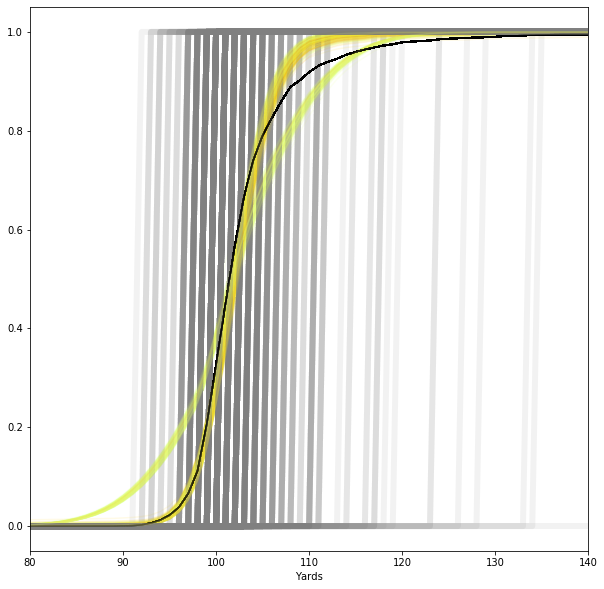

3 XBGDT ensemble:		 0.02332831331467661
5 NN ensemble:			 0.01442343988959276
5 NN + XBGDT ensemble:		 0.020551074575028378
(optimistic) Model free:	 0.014681112957526466


In [ ]:
plt.figure(figsize=(10,10))
model_free = np.mean(test_y, axis=0)



xgbt_score = np.sum(np.power(xgb_y_pred_cdfs.numpy()-test_y,2))/(199*(len(xgb_y_pred_cdfs)))
NN_score = np.sum(np.power(NN_cdfVals.numpy()-test_y,2))/(199*(len(NN_cdfVals)))

combo_score = np.sum(np.power(all_cdfVals.numpy()-test_y,2))/(199*(len(all_cdfVals)))
model_free_score = np.sum(np.power(model_free-test_y,2))/(199*(len(all_cdfVals)))

for i in range(test_y.shape[0]//10):
    c = plt.cm.Wistia((110 - test_y[i].sum())/10 - 1.3)
    plt.plot(test_y[i], alpha=3*150/all_cdfVals.shape[0], color='grey', linewidth=6)
    plt.plot(model_free, alpha=3*150/all_cdfVals.shape[0], color='black')
    plt.plot(all_cdfVals[i], alpha=3*150/all_cdfVals.shape[0], c=c)
plt.xlim(80, 140)
plt.xlabel("Yards")
plt.show()

print("3 XBGDT ensemble:\t\t {}".format(xgbt_score))
print("5 NN ensemble:\t\t\t {}".format(NN_score))
print("5 NN + XBGDT ensemble:\t\t {}".format(combo_score))
print("(optimistic) Model free:\t {}".format(model_free_score))


In [ ]:
 plt.figure(figsize=(10,10))

for i in range(test_y.shape[0]//10):
    c = plt.cm.Wistia((110 - test_y[i].sum())/15 - 0.3)
    plt.plot(abs(cdfVals[i].numpy() - test_y[i]), alpha=3*100/cdfVals.shape[0], color='blue')
plt.xlim(95, 125)
plt.show()

AttributeError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
test_y.sum(1).mean(), test_y[10].sum()

In [ ]:
temp_df = train_df.drop(['GameId', 'Yards'], axis=1)

temp_df = temp_df.infer_objects()
temp_df = temp_df.drop([col for col in temp_df.columns if 'PlayId' in col], axis=1)
temp_df = temp_df.drop([col for col in temp_df.columns if 'NflId' in col], axis=1)
temp_df = temp_df.select_dtypes(exclude=['object'])

temp_scaler = StandardScaler().fit(temp_df)
temp_df = pd.DataFrame(temp_scaler.transform(temp_df), columns=temp_df.keys())

clip_min = temp_df.quantile(0.1, axis=0)
clip_max = temp_df.quantile(0.9, axis=0)
temp_df = temp_df.clip(clip_min, clip_max, axis=1)

stdMask = temp_df.std() < 0.9
temp_df.loc[:, stdMask]

In [ ]:
break

In [ ]:
import pickle, codecs 

for nn_model in ensemble:
    pickled = pickle.loads(codecs.decode(pickled.encode(), 'base64')).decode()